# Development of Kinematics Plotting
[uproot Getting Started](https://uproot.readthedocs.io/en/latest/basic.html)

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

## Kinematic Calculations
The raw data gives us the Cartesian momentum values and the absolute energy values. Here we add a few more columns to the dataframe with higher-level kinematic variables like the recoil energy fraction and the outgoing recoil angle.

In [33]:
df = uproot.concatenate(['/hdfs/cms/user/eichl008/ldmx/sim-technique/ldmx/ntuple_electron_tungsten_depthmm_100.0_mAMeV_*.root:dbint/dbint'],library='pd')
df['recoil_pt'] = (df['recoil_px']**2 + df['recoil_py']**2)**(1/2)
df['energy_frac'] = (df['recoil_energy'] - df['incident_mass'])/(df['incident_energy']-df['incident_mass'])
df['recoil_angle'] = np.arctan2(df['recoil_pt'],df['recoil_pz'])

In [34]:
df

,x,y,z,incident_pdg,incident_genstatus,incident_mass,incident_energy,incident_px,incident_py,incident_pz,...,aprime_pdg,aprime_genstatus,aprime_mass,aprime_energy,aprime_px,aprime_py,aprime_pz,recoil_pt,energy_frac,recoil_angle
0,-3.685279e-06,-2.609193e-05,0.162024,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1000.0,8054.080097,-14.868856,8.980058,7991.739766,20.966040,0.002761,1.188652
1,2.300132e-04,-1.056390e-03,0.774262,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1000.0,6502.549842,2.789517,14.293199,6425.180338,35.038277,0.042721,0.102548
2,-6.973207e-05,1.468142e-04,0.503331,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1000.0,6769.782402,19.281186,1.799436,6695.489434,23.526849,0.162944,0.018042
3,-2.681544e-09,1.380099e-07,0.002511,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1000.0,6937.355766,169.936434,-71.526374,6862.427458,184.594871,0.144055,0.160798
4,1.616858e-05,-1.474235e-05,0.126416,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1000.0,8020.631192,-24.959344,-74.245601,7957.662304,77.971257,0.011045,1.070415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,-2.101734e-05,-1.446641e-05,0.158251,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1.0,7633.966192,-2.549481,-3.294470,7633.964990,1.879656,0.045717,0.005132
1999996,8.210290e-03,6.206365e-03,5.651881,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1.0,5333.858383,8.768928,14.380041,5333.831697,2.304021,0.013554,0.021150
1999997,-8.583303e-04,3.162548e-04,0.474062,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1.0,6487.452367,-12.478666,5.269157,6487.438148,2.681848,0.161613,0.002073
1999998,-6.210422e-04,-1.156555e-03,1.831340,11,1,0.510999,8000.510999,0.0,0.0,8000.510983,...,622,0,1.0,5840.425133,-0.905033,-11.461108,5840.413732,2.637403,0.195421,0.001686


## Plots
We plot the kinematic variables separated by A' mass.

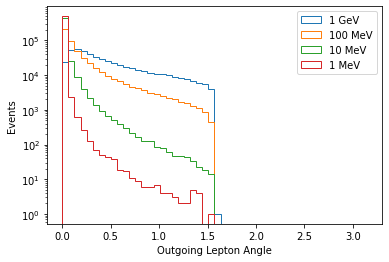

In [37]:
apmasses = {
    '1 GeV' : df['aprime_mass']==1000,
    '100 MeV' : df['aprime_mass']==100,
    '10 MeV' : df['aprime_mass']==10,
    '1 MeV' : df['aprime_mass']==1
}
for lab, sl in apmasses.items() :
    plt.hist(df[sl]['recoil_angle'], label=lab, 
             histtype='step',range=(0.,np.pi),bins=50)
plt.legend()
plt.yscale('log')
plt.xlabel('Outgoing Lepton Angle')
plt.ylabel('Events')
plt.show()

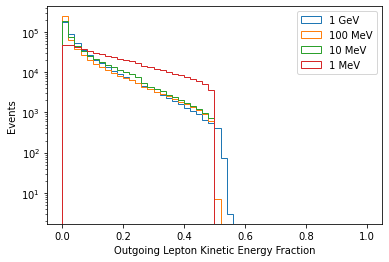

In [38]:
for lab, sl in apmasses.items() :
    plt.hist(df[sl]['energy_frac'], label=lab, 
             histtype='step', range=(0,1.),bins=50)
plt.legend()
plt.yscale('log')
plt.xlabel('Outgoing Lepton Kinetic Energy Fraction')
plt.ylabel('Events')
plt.show()

## Scratch

In [17]:
ef = uproot.open('../ntuple_electron_tungsten_depthmm_100.0_mAMeV_100_events_1_run_1.root')
ef['dbint/dbint'].arrays(library='pd')

,x,y,z,incident_pdg,incident_genstatus,incident_mass,incident_energy,incident_px,incident_py,incident_pz,...,recoil_px,recoil_py,recoil_pz,aprime_pdg,aprime_genstatus,aprime_mass,aprime_energy,aprime_px,aprime_py,aprime_pz
0,0.0,0.0,2.160016e-11,11,1,0.510999,4000.510999,0.0,0.0,4000.510966,...,0.0,0.0,29.817502,622,0,100.0,4069.429692,0.0,0.0,4068.200833


In [18]:
uf = uproot.open('../ntuple_muon_tungsten_depthmm_100.0_mAMeV_1000_events_1_run_1.root')
uf['dbint/dbint'].arrays(library='pd')

,x,y,z,incident_pdg,incident_genstatus,incident_mass,incident_energy,incident_px,incident_py,incident_pz,...,recoil_px,recoil_py,recoil_pz,aprime_pdg,aprime_genstatus,aprime_mass,aprime_energy,aprime_px,aprime_py,aprime_pz
0,0.0,0.0,0.004941,13,1,105.658372,100105.658372,0.0,0.0,100105.602612,...,0.00028,-0.00001,59.532078,622,0,1000.0,100979.375663,0.474266,-0.016419,100974.424035


# Comparison Table

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import dark_brem_lhe

In [6]:
def read(fp) :
    if 'dblib' in fp :
        if fp.endswith('.lhe') :
            df = dark_brem_lhe.DarkBremEventFile(fp).events
        else :
            df = dark_brem_lhe.DarkBremEventLibrary(fp).events()
    else :
        with uproot.open(fp) as f :
            df = f['dbint/dbint'].arrays(library='pd')
    df['recoil_pt'] = (df['recoil_px']**2 + df['recoil_py']**2)**(1/2)
    df['energy_frac'] = (df['recoil_energy'] - df['incident_mass'])/(df['incident_energy']-df['incident_mass'])
    df['recoil_angle'] = np.arctan2(df['recoil_pt'],df['recoil_pz'])
    return df

In [7]:
el_data = {
    'MG' : read('../dblib/electron_tungsten_MaxE_4.0_MinE_0.2_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000/electron_tungsten_MaxE_4.0_MinE_0.2_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000_IncidentEnergy_4.0_unweighted_events.lhe'),
    'MGS' : read('../lower_floor/ntuple_electron_tungsten_depthmm_100.0_mAMeV_100_events_50000_run_3000.root'),
    'DMG4' : read('../lower_floor/ntuple_electron_tungsten_depthmm_100.0_mAMeV_100_events_50000_run_1.root'),
}
mu_data = {
    'MG' : read('../dblib/muon_copper_MaxE_100.0_MinE_2.0_RelEStep_0.1_UndecayedAP_mA_1.0_run_3000/muon_copper_MaxE_100.0_MinE_2.0_RelEStep_0.1_UndecayedAP_mA_1.0_run_3000_IncidentEnergy_100.0_unweighted_events.lhe'),
    'MGS' : read('../lower_floor/ntuple_muon_brass_depthmm_100.0_mAMeV_1000_events_50000_run_3000.root'),
    'DMG4' : read('../lower_floor/ntuple_muon_brass_depthmm_100.0_mAMeV_1000_events_50000_run_1.root')
}

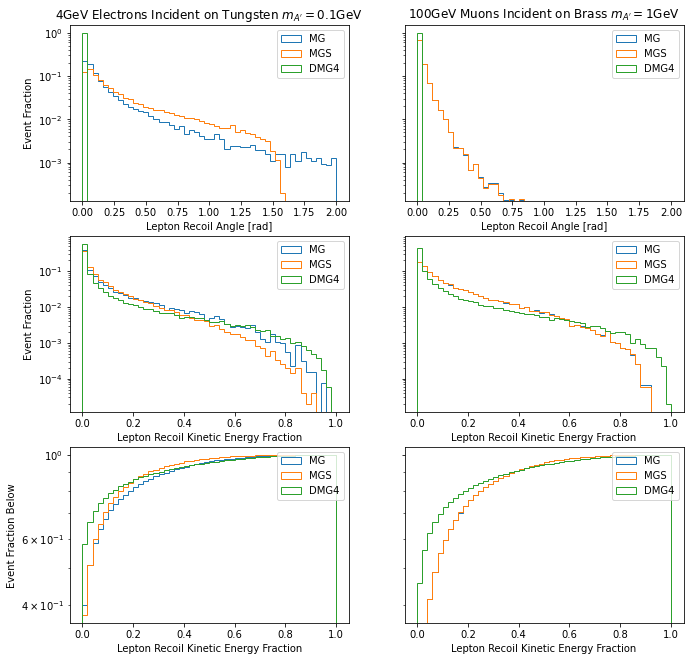

In [32]:
fig, ((e_ang,m_ang),(e_ke,m_ke),(e_ke_cm,m_ke_cm)) = plt.subplots(ncols = 2, nrows = 3, sharey='row')
fig.set_size_inches(11,11)

e_ang.set_xlabel('Lepton Recoil Angle [rad]')
e_ang.set_yscale('log')
e_ang.set_ylabel('Event Fraction')
e_ang.set_title('4GeV Electrons Incident on Tungsten $m_{A\'}=0.1$GeV')
for name, df in el_data.items() :
    e_ang.hist(df['recoil_angle'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
               label=name,
               histtype='step',range=(0.,2.),bins=50)
e_ang.legend()

m_ang.set_xlabel('Lepton Recoil Angle [rad]')
m_ang.set_title('100GeV Muons Incident on Brass $m_{A\'}=1$GeV')
for name, df in mu_data.items() :
    m_ang.hist(df['recoil_angle'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
               label=name,
               histtype='step',range=(0.,2.0),bins=50)
m_ang.legend()

e_ke.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
e_ke.set_yscale('log')
e_ke.set_ylabel('Event Fraction')
for name, df in el_data.items() :
    e_ke.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
              label=name,
               histtype='step',range=(0.,1.),bins=50)
e_ke.legend(loc='best')

m_ke.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
for name, df in mu_data.items() :
    m_ke.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
              label=name,
               histtype='step',range=(0.,1.),bins=50)
m_ke.legend(loc='best')

e_ke_cm.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
e_ke_cm.set_yscale('log')
e_ke_cm.set_ylabel('Event Fraction Below')
for name, df in el_data.items() :
    e_ke_cm.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name, cumulative=True,
               histtype='step',range=(0.,1.),bins=50)
e_ke_cm.legend(loc='best')

m_ke_cm.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
for name, df in mu_data.items() :
    m_ke_cm.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name, cumulative=True,
                 histtype='step',range=(0.,1.),bins=50)
m_ke_cm.legend(loc='best')
      
plt.show()

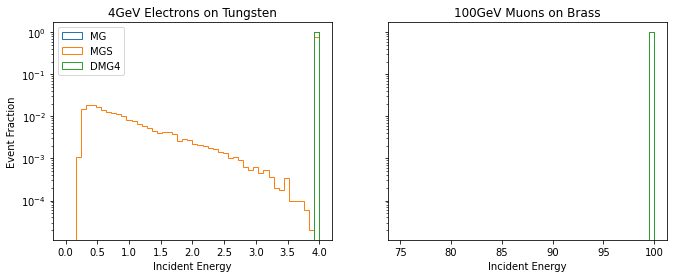

In [30]:
fig, ((e,m)) = plt.subplots(ncols=2,nrows=1,sharey=True)
fig.set_size_inches(11,4)
e.set_title('4GeV Electrons on Tungsten')
e.set_xlabel('Incident Energy')
e.set_yscale('log')
e.set_ylabel('Event Fraction')
for name, df in el_data.items() :
    MeV_to_GeV = 1.
    shift = 0.
    if name != 'MG' :
        MeV_to_GeV = 1./1000
        shift = 0.511 #MeV
    e.hist((df['incident_energy']-shift)*MeV_to_GeV,weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name,
               histtype='step',range=(0.,4.),bins=50)
e.legend(loc='upper left')

m.set_title('100GeV Muons on Brass')
m.set_xlabel('Incident Energy')
for name, df in mu_data.items() :
    shift=0.
    MeV_to_GeV = 1.
    if name != 'MG' :
        MeV_to_GeV = 1./1000
        shift = 105.66 #MeV
    m.hist((df['incident_energy']-shift)*MeV_to_GeV,weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name,
                 histtype='step',range=(75.,100.),bins=50)

plt.show()

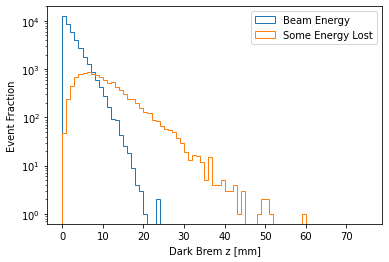

In [52]:
inc_e_cuts = {
    'Beam Energy' : el_data['MGS']['incident_energy']>4000,
    'Some Energy Lost' : el_data['MGS']['incident_energy']<=4000
}
for name, sl in inc_e_cuts.items() :
    plt.hist(el_data['MGS'][sl]['z'],
             bins=75,range=(0.,75.),histtype='step',label=name)
plt.yscale('log')
plt.xlabel('Dark Brem z [mm]')
plt.ylabel('Event Fraction')
plt.legend()
plt.show()